In [47]:
import torch 
from torch.nn import functional as F
from icecream import ic 
from sys import exit as e 
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
import random
import json
import glob
import pickle
import time
from collections import Counter
random.seed(42)

import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (20, 16)

In [48]:
def build_dataset(words, stoi, block_size):
  X = []
  y = []
  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      X.append(context)
      y.append(stoi[ch])

      context = context[1:] + [stoi[ch]]
  X = torch.tensor(X)
  y = torch.tensor(y)

  return X, y

In [49]:
words = open("./data/names.txt", "r").read().splitlines()
block_size = 3
unique_chars = sorted(list(set(''.join(words))))


stoi = {s: i+1 for i, s in enumerate(unique_chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}


In [50]:
random.shuffle(words)
t1 = int(0.8 * len(words))
t2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:t1], stoi, block_size)
X_val, y_val = build_dataset(words[t1:t2], stoi, block_size)
X_test, y_test = build_dataset(words[t2:], stoi, block_size)


In [51]:
ic(X_train.shape, y_train.shape)
ic(X_val.shape, y_val.shape)
ic(X_test.shape, y_test.shape)

ic| X_train.shape: torch.Size([182625, 3])
    y_train.shape: torch.Size([182625])
ic| X_val.shape: torch.Size([22655, 3])
    y_val.shape: torch.Size([22655])
ic| X_test.shape: torch.Size([22866, 3])
    y_test.shape: torch.Size([22866])


(torch.Size([22866, 3]), torch.Size([22866]))

In [52]:
emb_dim =10
input_dim = block_size * emb_dim
hidden = 200
vocab_size = len(unique_chars) + 1
input_dim

30

In [53]:

g = torch.Generator().manual_seed(2147483647)
# C = torch.randn((vocab_size, emb_dim), generator=g)
C = torch.randn((vocab_size, emb_dim), requires_grad=True, generator=g)
W1 = torch.randn((input_dim, hidden), requires_grad=True, generator = g)
b1 = torch.randn((hidden), requires_grad=True, generator=g)
W2 = torch.randn((hidden, vocab_size), requires_grad=True, generator=g)
b2 = torch.randn((vocab_size), requires_grad=True, generator=g)
parameters = [C, W1, b1, W2, b2]
n = sum(p.nelement() for p in parameters)
n


11897

In [54]:

for p in parameters:
  p.requires_grad=True



In [55]:
lri = []
total_loss = []
steps = []

In [56]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (32,))
  
  # forward pass
  emb = C[X_train[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, y_train[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  # with torch.no_grad():
  total_loss.append(loss.log10().item())
  steps.append(i)

  # # track stats
  # #lri.append(lre[i])
  # stepi.append(i)
  # lossi.append(loss.log10().item())


In [57]:
# n_iters = 200000
# batch_size = 32

# for epoch in range(n_iters):
#   idx = torch.randint(0, X_train.shape[0], (batch_size,))

#   # FORWARD PASS
#   # NOTE: Notice that a (27, 2) is indexed by a (D, 3) integer tensor
#   emb = C[X_train[idx]]
#   h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1)
#   logits = h @ W2 + b2
#   # NOTE: CE is more efficient in pytorch. 
#   # NOTE: CE is numerically well-behaved in torch. logits - torch.max(logits) 
#   loss = F.cross_entropy(logits, y_train[idx]) 

#   lr = 0.1 if epoch < 100000 else 0.01
#   # BACKWARD PASS
#   for p in parameters:
#     p.grad = None
#   loss.backward()
#   for p in parameters:
#     p.data += -lr * p.grad 
#   with torch.no_grad():
#     total_loss.append(loss.log10().item())
#     steps.append(epoch)
#     # lri.append(lre[epoch])
# print(loss.item())


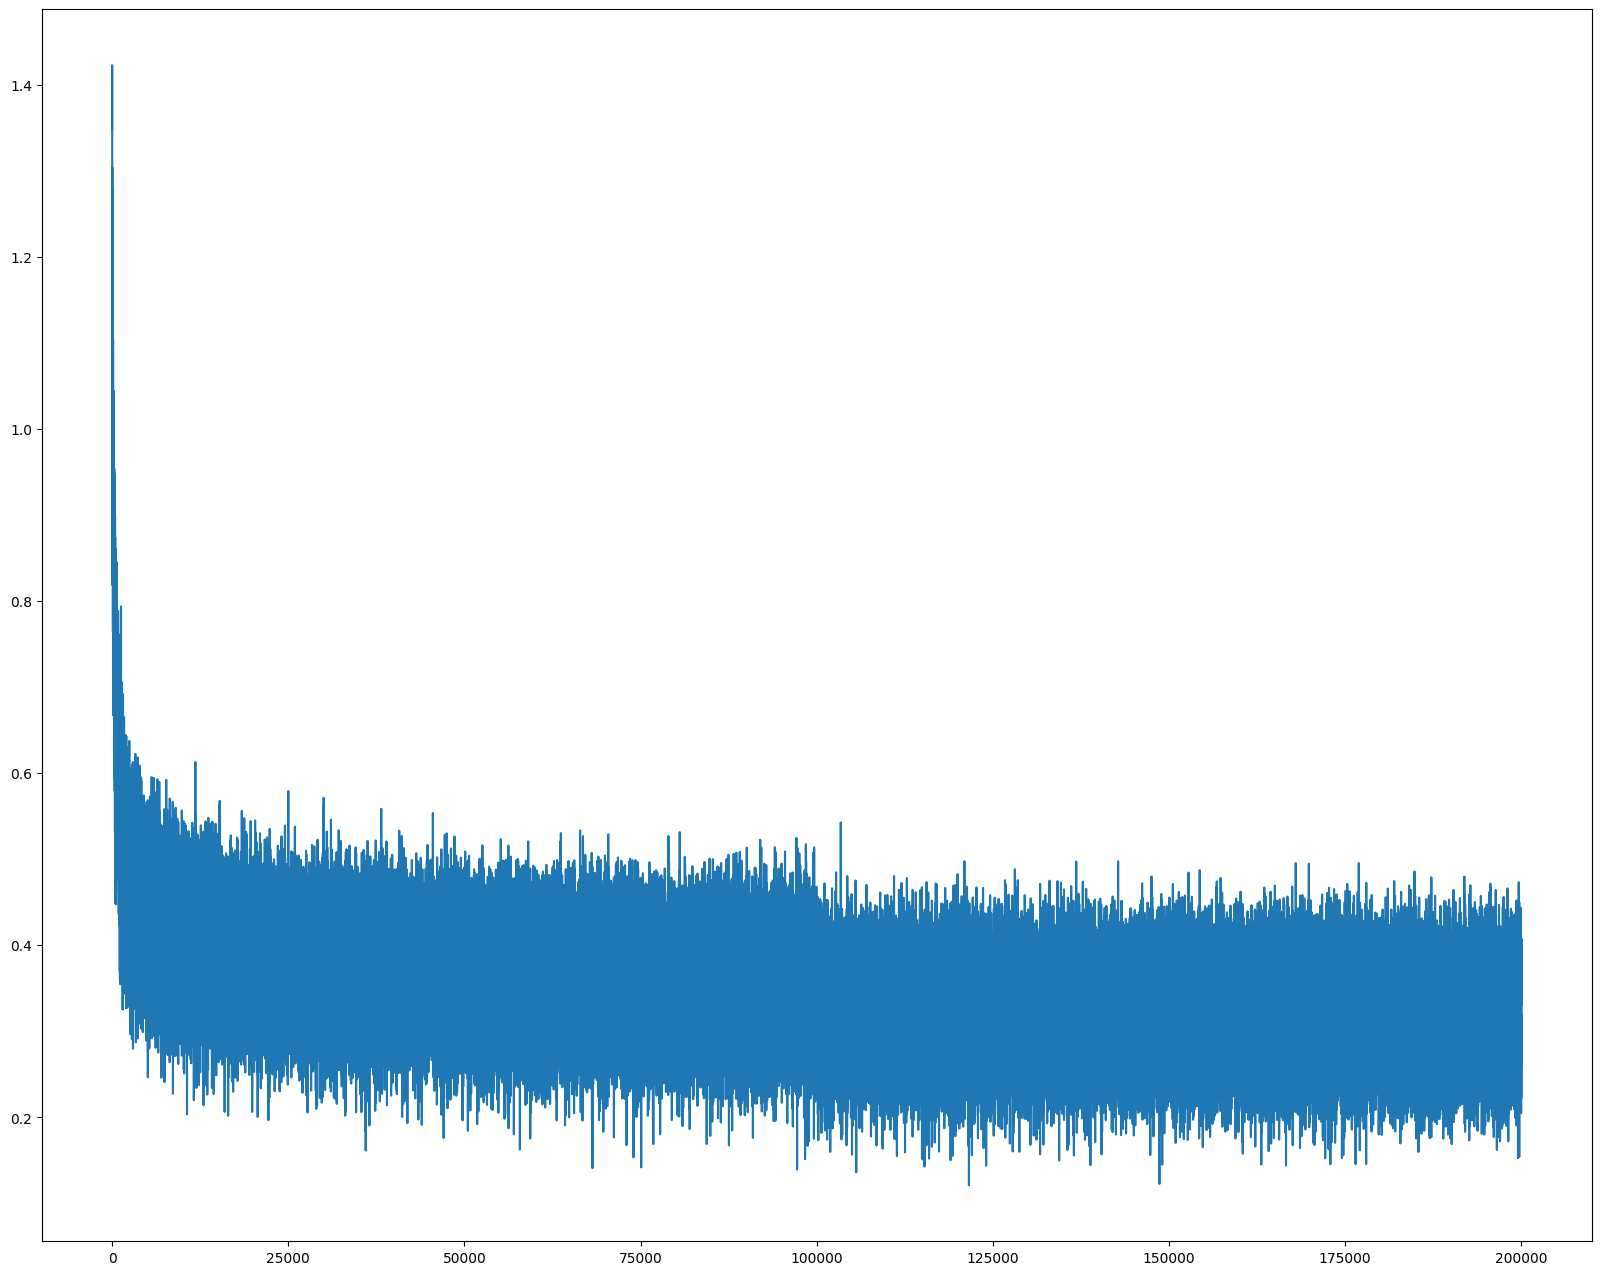

In [58]:
plt.plot(steps, total_loss)
plt.show()

In [59]:
with torch.no_grad():
  emb_val = C[X_train]
  h = torch.tanh(emb_val.view(-1, input_dim) @ W1 + b1)
  logits = h @ W2 + b2
  val_loss = F.cross_entropy(logits, y_train)
  ic(val_loss)


ic| val_loss: tensor(2.1173)


In [60]:
with torch.no_grad():
  emb_val = C[X_val]
  h = torch.tanh(emb_val.view(-1, input_dim) @ W1 + b1)
  logits = h @ W2 + b2
  val_loss = F.cross_entropy(logits, y_val)
  ic(val_loss)


ic| val_loss: tensor(2.1574)


In [61]:
with torch.no_grad():
  emb_test = C[X_test]
  h = torch.tanh(emb_test.view(-1, input_dim) @ W1 + b1)
  logits = h @ W2 + b2
  val_loss = F.cross_entropy(logits, y_test)
  ic(val_loss)


ic| val_loss: tensor(2.1568)


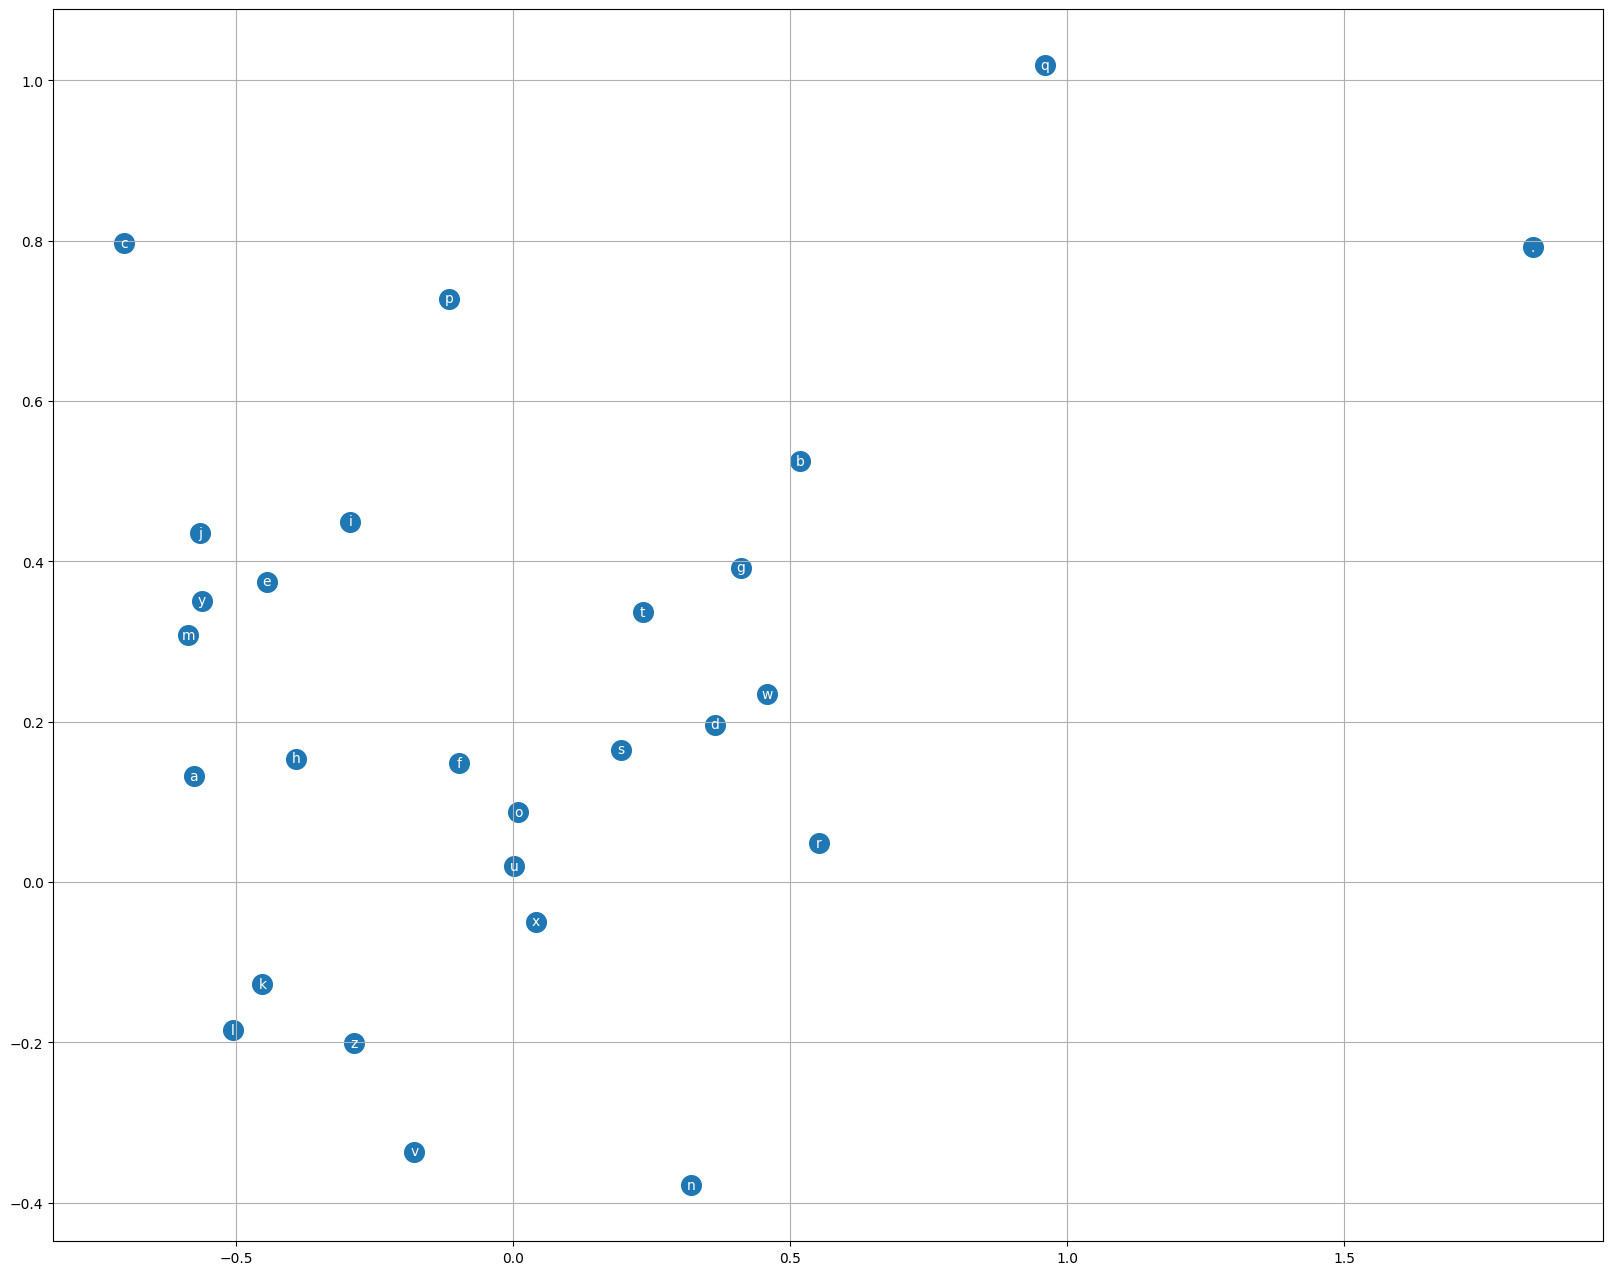

In [62]:
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), s=itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [63]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

moha.
gryanziee.
madhayla.
rethan.
emdrae.
cadee.
daeliianni.
jen.
edelleana.
arlelle.
malara.
nyshabergiairiel.
kindreelle.
jettocon.
brence.
ryyah.
fael.
yuma.
myston.
azhia.
